<a href="https://colab.research.google.com/github/JuanParias29/ML_Classification_Model/blob/main/AUC_ROCipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

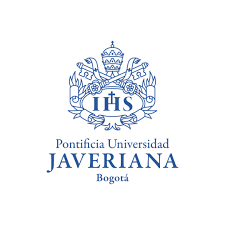

# **Pontificia Universidad Javeriana**
# **Procesamiento de Alto Volumen de Datos**
____________________________________________________

**Autores:** Juan Pablo Arias Buitrago y Paula Andrea Velasquez Romero

**Carrera:** Ciencia de Datos

**Semestre:** 5°

**Fecha:** 28 de Abril de 2025

**Objetivo**: Uso de PySpark para crear modelos de clasificación y evaluar su rendimiento

---

## Bibliotecas necesarias

In [38]:
!pip install pyspark findspark

In [39]:
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.11/dist-packages/pyspark'

In [40]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()

import pyspark

from pylab import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count, isnull, round
from pyspark.ml.feature import Imputer


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F     #Permite creación de Funciones Creadas por el USUARIO
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

## Carga y contenido de los datos

In [41]:
# Cargar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#Carga de datos
datos = '/content/drive/MyDrive/BIG DATA/P2 y Presentacion Metricas/water_potability_Mod_A.csv'

#Objeto Dataframe spark
df_WaterPotability_Mod_A = spark.read.csv(datos, header=True, inferSchema=True)

## Muestra de Datos
df00 = df_WaterPotability_Mod_A
df00.show(10)

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|              NULL| 204.8904554713363|20791.318980747026| 7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|  3.71608007538699|129.42292051494425|18630.057857970347|    6.635245883862|              NULL| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
| 8.099124189298397|224.23625939355776|19909.541732292393| 9.275883602694089|   

### **Contenido de los Datos**

1. **pH:**
El PH es un parámetro importante para evaluar el equilibrio ácido-base del agua. También es el indicador del estado ácido o alcalino del agua.
- La OMS ha recomendado un límite máximo permisible de pH de 6,5 a 8,5.
3. **Hardness:**
La dureza "Hardness" está causada principalmente por las sales de calcio y magnesio. Estas sales se disuelven a partir de depósitos geológicos por los que pasa el agua. El tiempo que el agua está en contacto con el material que produce la dureza ayuda a determinar cuánta dureza hay en el agua bruta.
- La dureza se define originalmente como la capacidad del agua para precipitar el jabón causado por el calcio y el magnesio.
4. **Solids:**
Sólidos totales disueltos (TDS): El agua tiene la capacidad de disolver una amplia gama de minerales inorgánicos y algunos minerales orgánicos o sales como potasio, calcio, sodio, bicarbonatos, cloruros, magnesio, sulfatos, etc. Estos minerales producen un sabor no deseado y diluyen el color en apariencia del agua. Este es un parámetro importante para el uso del agua. El agua con un alto valor de TDS indica que el agua está muy mineralizada.
- El límite deseable de TDS es de 500 mg/l y el límite máximo es de 1000 mg/l, prescrito para el consumo humano.
5. **Chloramines:**
El cloro y la cloramina son los principales desinfectantes utilizados en los sistemas públicos de abastecimiento de agua. Las cloraminas se forman normalmente cuando se añade amoniaco al cloro para tratar el agua potable.
- Los niveles de cloro de hasta 4 miligramos por litro (mg/L o 4 partes por millón (ppm)) se consideran seguros en el agua potable.
6. **Sulfate:**
Los sulfatos son sustancias naturales que se encuentran en los minerales, el suelo y las rocas. Están presentes en el aire ambiente, las aguas subterráneas, las plantas y los alimentos. El principal uso comercial de los sulfatos es la industria química. La concentración de sulfato en el agua de mar es de unos 2.700 miligramos por litro (mg/L).
- Oscila entre 3 y 30 mg/L en la mayoría de los suministros de agua dulce, aunque en algunos lugares geográficos se encuentran concentraciones mucho más elevadas (1.000 mg/L).
7. **Conductivity:**
El agua pura no es un buen conductor de la corriente eléctrica, más bien es un buen aislante. El aumento de la concentración de iones aumenta la conductividad eléctrica del agua. Generalmente, la cantidad de sólidos disueltos en el agua determina la conductividad eléctrica. La conductividad eléctrica (CE) mide en realidad el proceso iónico de una solución que le permite transmitir la corriente.
- Según las normas de la OMS, el valor de la CE no debe superar los 400 μS/cm.
8. **Organic_carbon:**
El carbono orgánico total (COT) de las aguas de origen procede tanto de la materia orgánica natural en descomposición (NOM) como de fuentes sintéticas. El COT es una medida de la cantidad total de carbono en compuestos orgánicos en el agua pura.
- Según la EPA de EE.UU., < 2 mg/L de COT en agua tratada/potable y < 4 mg/L en agua de origen que se utiliza para el tratamiento.
9. **Trihalomethanes:**
Los THM son sustancias químicas que pueden encontrarse en el agua tratada con cloro. La concentración de THM en el agua potable varía según el nivel de materia orgánica del agua, la cantidad de cloro necesaria para tratar el agua y la temperatura del agua tratada.
- Los niveles de THM de hasta 80 ppm se consideran seguros en el agua potable.
10. **Turbidity:**
La turbidez del agua depende de la cantidad de materia sólida presente en estado de suspensión. Es una medida de las propiedades de emisión de luz del agua y la prueba se utiliza para indicar la calidad del vertido de residuos con respecto a la materia coloidal.
- El valor medio de turbidez presente es de 0,98 NTU (es inferior al valor recomendado por la OMS de 5,00 NTU).
11. **Potability:**
Indica si el agua es segura para el consumo humano, donde 1 significa Potable y 0 significa No potable.

## Limpieza y transformación de datos

In [43]:
# Tipos de datos
df00.dtypes

[('ph', 'double'),
 ('Hardness', 'double'),
 ('Solids', 'double'),
 ('Chloramines', 'double'),
 ('Sulfate', 'double'),
 ('Conductivity', 'double'),
 ('Organic_carbon', 'double'),
 ('Trihalomethanes', 'double'),
 ('Turbidity', 'double'),
 ('Potability', 'int')]

In [44]:
#Cantidad total de registros
df00.count()

3276

In [45]:
#Tabla datos núlos o imposibles
df00.select([count(when(isnull(c) | isnan(c), c)).alias(c) for c in df00.columns]).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



In [46]:
df00.createOrReplaceTempView("df00_sql")

In [47]:
# Porcentaje de Datos Nulos por columnas
#Nota: Use la función para determinar el porcentaje de datos nulos por columnas

def porcentajeDatosNulosX_Columna(df00):
    """
    Esta función toma un DataFrame de PySpark como entrada y devuelve un diccionario con
    columnas que tienen valores perdidos y el porcentaje de valores perdidos en cada columna.

    paramétro df: PySpark DataFrame
    retorna: DataFrame con los nombres de las columnas y el porcentaje de valores perdidos en cada columna
    """
    # Total de registros del dataframe
    total = df00.count()

    # cantidad de datos nulos por columna
    df00_nulos = df00.agg(*[count(when(isnull(c) | isnan(c), c)).alias(c) for c in df00.columns])

    # Colección a diccionario
    cant_nulos = df00_nulos.collect()[0].asDict()

    # Calculo de porcentaje por columna y presentación en diccionario
    porcentajeNulos = {column: (value / total) * 100 for column, value in cant_nulos.items()}

    # Filtrar solo los valores nulos
    porcentajeNulos = {column: value for column, value in porcentajeNulos.items() if value > 0}

    porcentajeNulos = spark.createDataFrame([(k, v) for k, v in porcentajeNulos.items()], ["Columnas","Porciento_Nulos"])
    porcientoNulos = porcentajeNulos.withColumn("Porciento_Nulos", round(porcentajeNulos["Porciento_Nulos"], 2))
    porcientoNulos = porcientoNulos.sort("Porciento_Nulos", ascending=False)

    return porcientoNulos

In [48]:
#Presente la tabla Porcentaje valores nulos
valoresNulos = porcentajeDatosNulosX_Columna(df00)
valoresNulos.show()

+---------------+---------------+
|       Columnas|Porciento_Nulos|
+---------------+---------------+
|        Sulfate|          23.84|
|             ph|          14.99|
|Trihalomethanes|           4.95|
+---------------+---------------+



In [49]:
#Eliminar datos que el promedio sea menor al 10%
porcentajes_nulos_dict = valoresNulos.rdd.map(lambda row: (row['Columnas'], row['Porciento_Nulos'])).collectAsMap()

#Se hace la consulta, que retorna el df00 con la(s) columnas con valores menor al 10% nulos, que se llamará df01
df01 = df00.select([c for c in df00.columns if porcentajes_nulos_dict.get(c, 0) < 10])

#Se verifica la eliminación
df01.show(15)

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|          Hardness|            Solids|       Chloramines|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
| 204.8904554713363|20791.318980747026| 7.300211873184757| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|129.42292051494425|18630.057857970347|    6.635245883862| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|224.23625939355776|19909.541732292393| 9.275883602694089| 418.6062130644815|16.868636929550973| 66.42009251176368|3.0559337496641685|         0|
|214.37339408562252|22018.417440775294|  8.05933237743854| 363.2665161642437|18.436524495493302|100.34167436508008| 4.628770

In [50]:
#Imputar valores que superen umbral del 10% de datos nulos por el promedio

# Inicializar el Imputador
imputador = Imputer(
    inputCols= df00.columns, #Nombres de las columnas del dataframe spark
    outputCols=df00.columns, #Nombre de las columnas del dataframe spark <salida>
    strategy="mean"          # valor a imputar por NULO <puede ser mediana, o cualquier medida de tendencia central>
)

#Ajustar el imputador
modelo = imputador.fit(df00)

#Imputar el dataframe <valores nulos por columnas que superen el umbral del 10%>
df02 = modelo.transform(df00)

#Verificación de la imputación de los nulos
df02.select([count(when(isnull(c) | isnan(c), c)).alias(c) for c in df02.columns]).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



##Visualización de los datos

In [51]:
#Creación de tablas con datos limpios para visualizar los datos
df02.createOrReplaceTempView("df02_sql")

In [52]:
#Hacer los vectores de la tabla para cada parámetro
PH_parametro = spark.sql("Select ph from df02_sql")
PH_parametro = PH_parametro.rdd.map(lambda fila: fila.ph).collect()

Hardness_parametro = spark.sql("Select Hardness from df02_sql")
Hardness_parametro = Hardness_parametro.rdd.map(lambda fila: fila.Hardness).collect()

Solids_parametro = spark.sql("Select Solids from df02_sql")
Solids_parametro = Solids_parametro.rdd.map(lambda fila: fila.Solids).collect()

Chloramines_parametro = spark.sql("Select Chloramines from df02_sql")
Chloramines_parametro = Chloramines_parametro.rdd.map(lambda fila: fila.Chloramines).collect()

Sulfate_parametro = spark.sql("Select Sulfate from df02_sql")
Sulfate_parametro = Sulfate_parametro.rdd.map(lambda fila: fila.Sulfate).collect()

Conductivity_parametro = spark.sql("Select Conductivity from df02_sql")
Conductivity_parametro = Conductivity_parametro.rdd.map(lambda fila: fila.Conductivity).collect()

Organic_carbon_parametro = spark.sql("Select Organic_carbon from df02_sql")
Organic_carbon_parametro = Organic_carbon_parametro.rdd.map(lambda fila: fila.Organic_carbon).collect()

Trihalomethanes_parametro = spark.sql("Select Trihalomethanes from df02_sql")
Trihalomethanes_parametro = Trihalomethanes_parametro.rdd.map(lambda fila: fila.Trihalomethanes).collect()

Turbidity_parametro = spark.sql("Select Turbidity from df02_sql")
Turbidity_parametro = Turbidity_parametro.rdd.map(lambda fila: fila.Turbidity).collect()

Potability_parametro = spark.sql("Select Potability from df02_sql")
Potability_parametro = Potability_parametro.rdd.map(lambda fila: fila.Potability).collect()

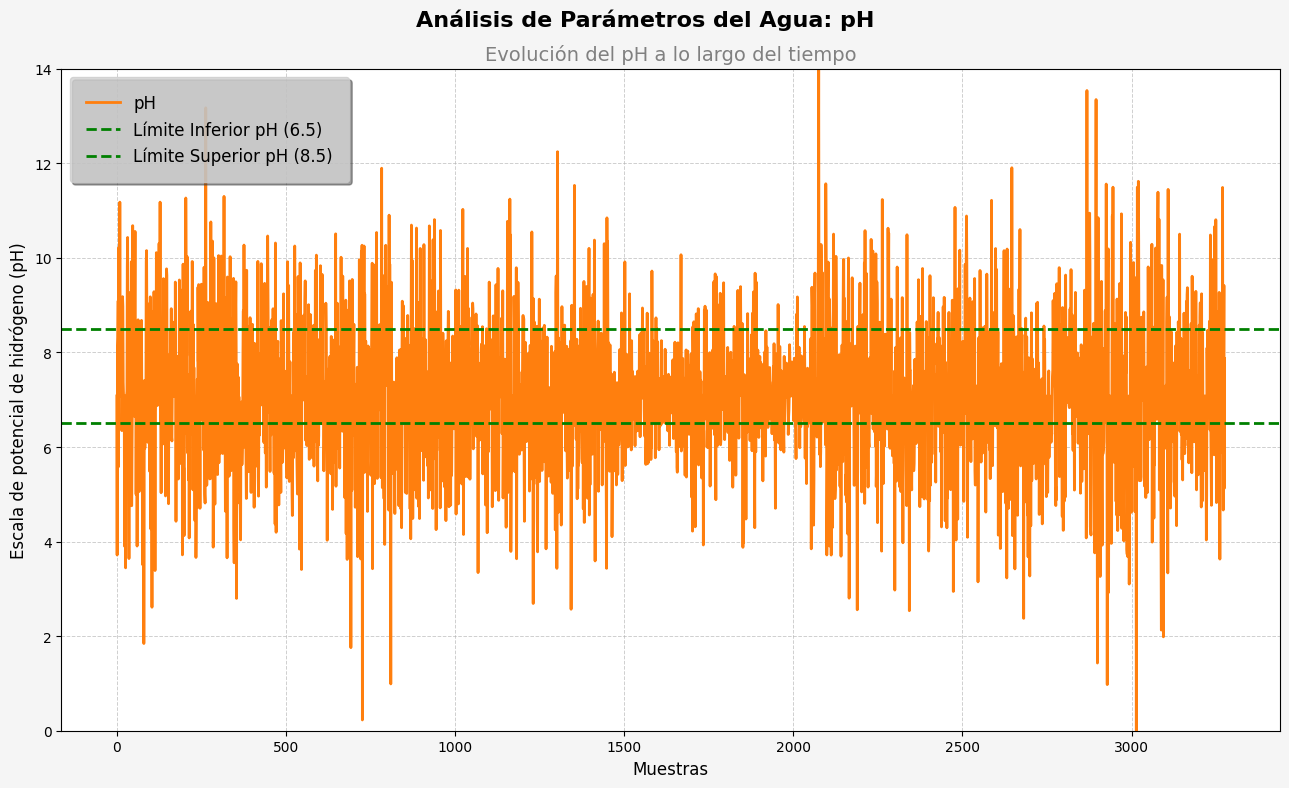

In [53]:
# Graficar el parámetro pH
tam = len(PH_parametro)
fig, ax2 = plt.subplots(figsize=(13, 8))
ax2.plot(range(0, tam), PH_parametro, label='pH', color='tab:orange', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: pH', fontsize=16, fontweight='bold', color='black')
ax2.set_title('Evolución del pH a lo largo del tiempo', fontsize=14, color='grey')
ax2.set_xlabel('Muestras', fontsize=12)
ax2.set_ylabel('Escala de potencial de hidrógeno (pH)', fontsize=12)

# Agregar líneas horizontales que indican el rango de pH adecuado para agua
ax2.axhline(y=6.5, color='green', linestyle='--', label='Límite Inferior pH (6.5)', linewidth=2)
ax2.axhline(y=8.5, color='green', linestyle='--', label='Límite Superior pH (8.5)', linewidth=2)
ax2.set_ylim(0, 14)

# Leyenda
legend = ax2.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')

# Activar la cuadrícula
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Establecer el fondo del gráfico
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

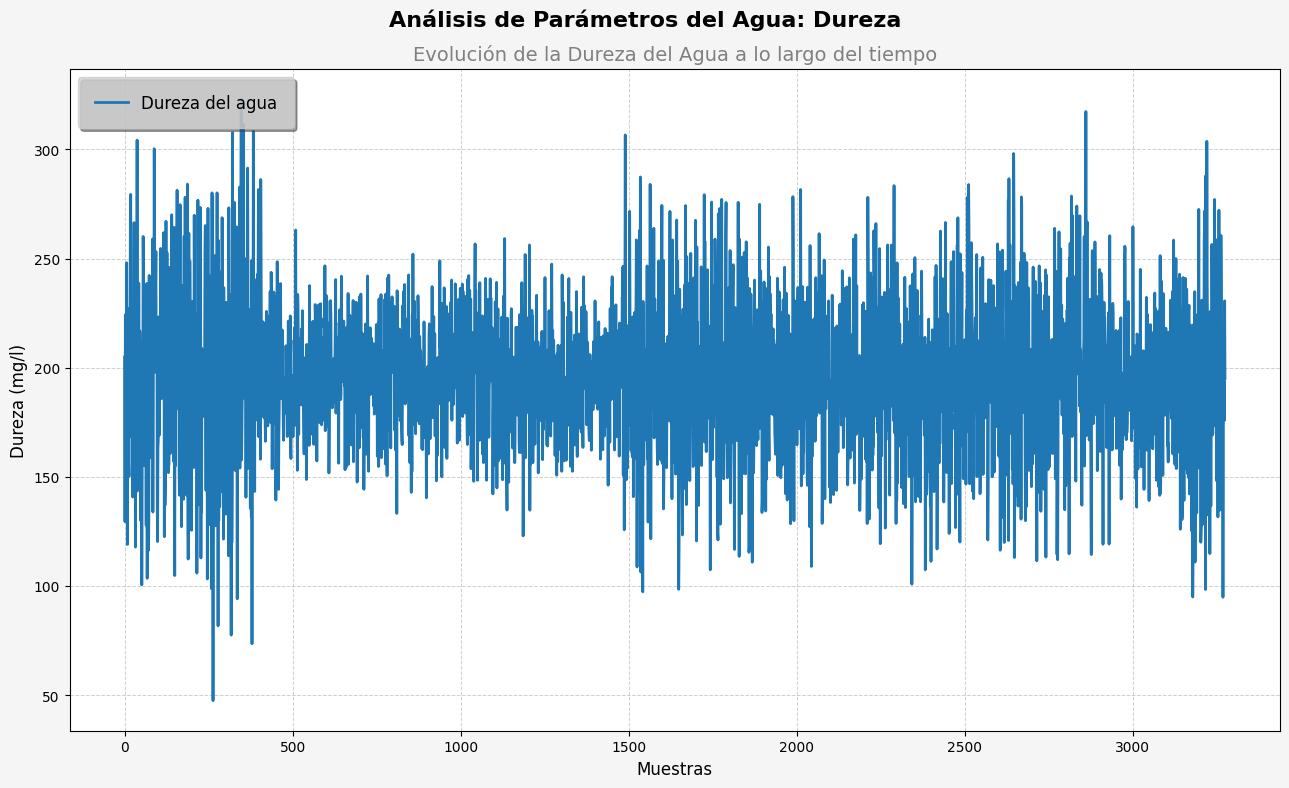

In [54]:
# Graficar el parámetro Hardness
tam = len(Hardness_parametro)
fig, ax1 = plt.subplots(figsize=(13, 8))
ax1.plot(range(0, tam), Hardness_parametro, label='Dureza del agua', color='tab:blue', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Dureza', fontsize=16, fontweight='bold', color='black')
ax1.set_title('Evolución de la Dureza del Agua a lo largo del tiempo', fontsize=14, color='grey')
ax1.set_xlabel('Muestras', fontsize=12)
ax1.set_ylabel('Dureza (mg/l)', fontsize=12)

# Leyenda
legend = ax1.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

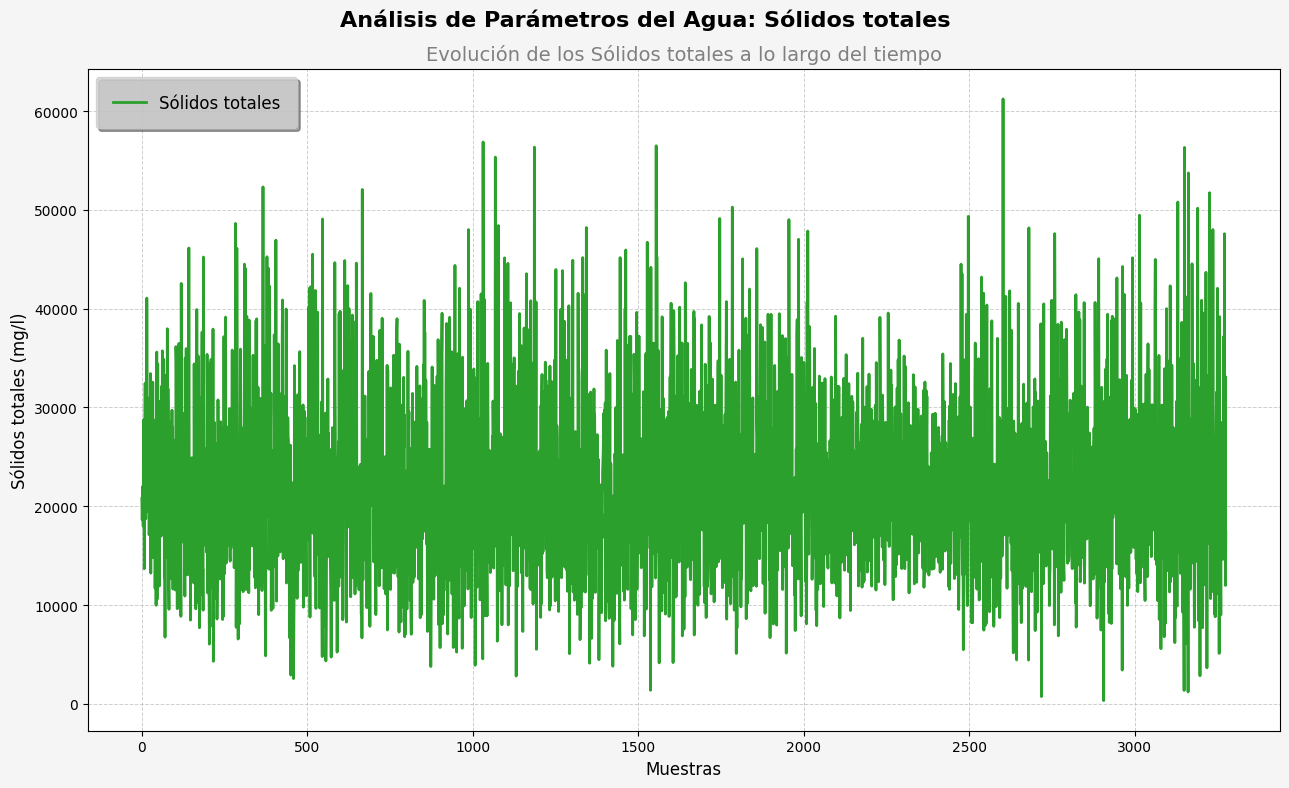

In [55]:
# Graficar el parámetro Solids
tam = len(Solids_parametro)
fig, ax3 = plt.subplots(figsize=(13, 8))
ax3.plot(range(0, tam), Solids_parametro, label='Sólidos totales', color='tab:green', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Sólidos totales', fontsize=16, fontweight='bold', color='black')
ax3.set_title('Evolución de los Sólidos totales a lo largo del tiempo', fontsize=14, color='grey')
ax3.set_xlabel('Muestras', fontsize=12)
ax3.set_ylabel('Sólidos totales (mg/l)', fontsize=12)

# Agregar líneas horizontales que indican el rango de solids segun la OMS
ax2.axhline(y=500, color='black', linestyle='--', label='Límite Inferior pH (6.5)', linewidth=2)
ax2.axhline(y=1000, color='black', linestyle='--', label='Límite Superior pH (8.5)', linewidth=2)
ax2.set_ylim(0, 14)

# Leyenda
legend = ax3.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax3.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

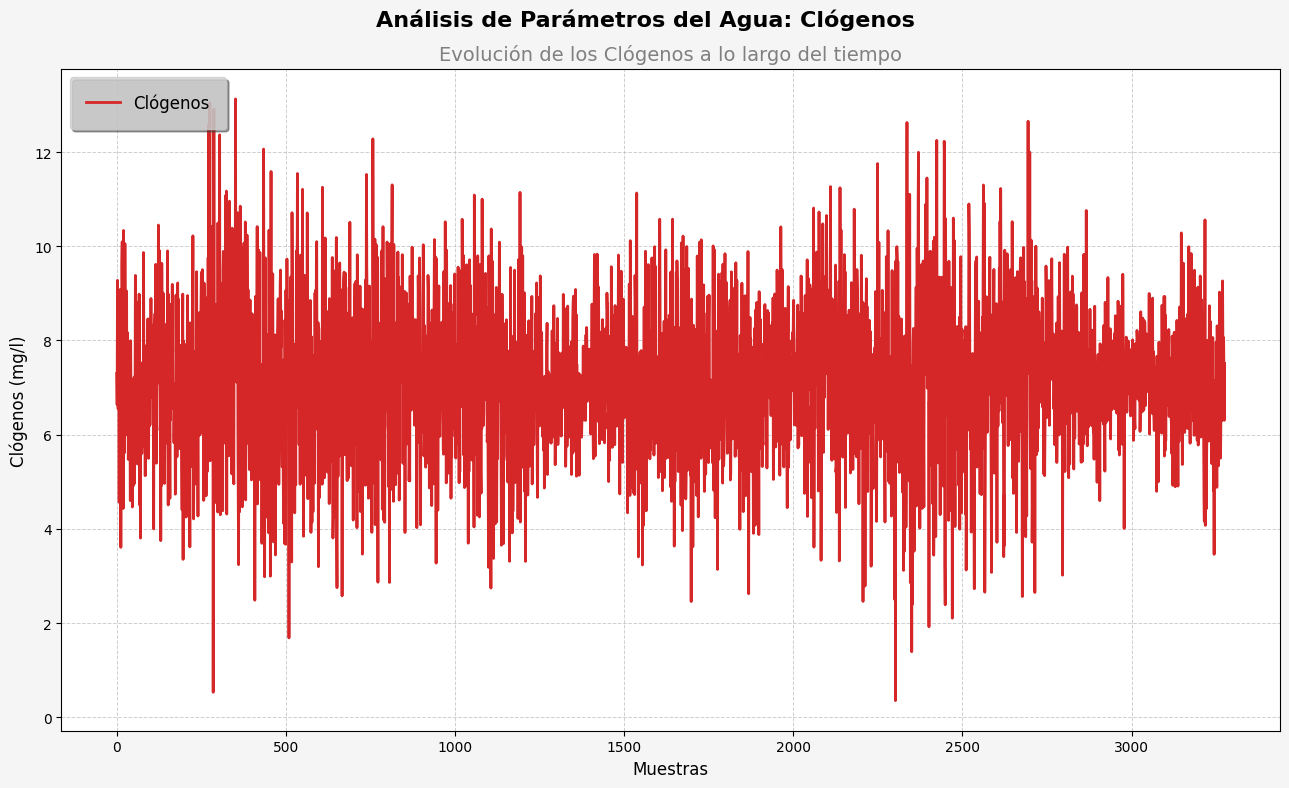

In [56]:
# Graficar el parámetro Chloramines
tam = len(Chloramines_parametro)
fig, ax4 = plt.subplots(figsize=(13, 8))
ax4.plot(range(0, tam), Chloramines_parametro, label='Clógenos', color='tab:red', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Clógenos', fontsize=16, fontweight='bold', color='black')
ax4.set_title('Evolución de los Clógenos a lo largo del tiempo', fontsize=14, color='grey')
ax4.set_xlabel('Muestras', fontsize=12)
ax4.set_ylabel('Clógenos (mg/l)', fontsize=12)

# Leyenda
legend = ax4.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax4.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

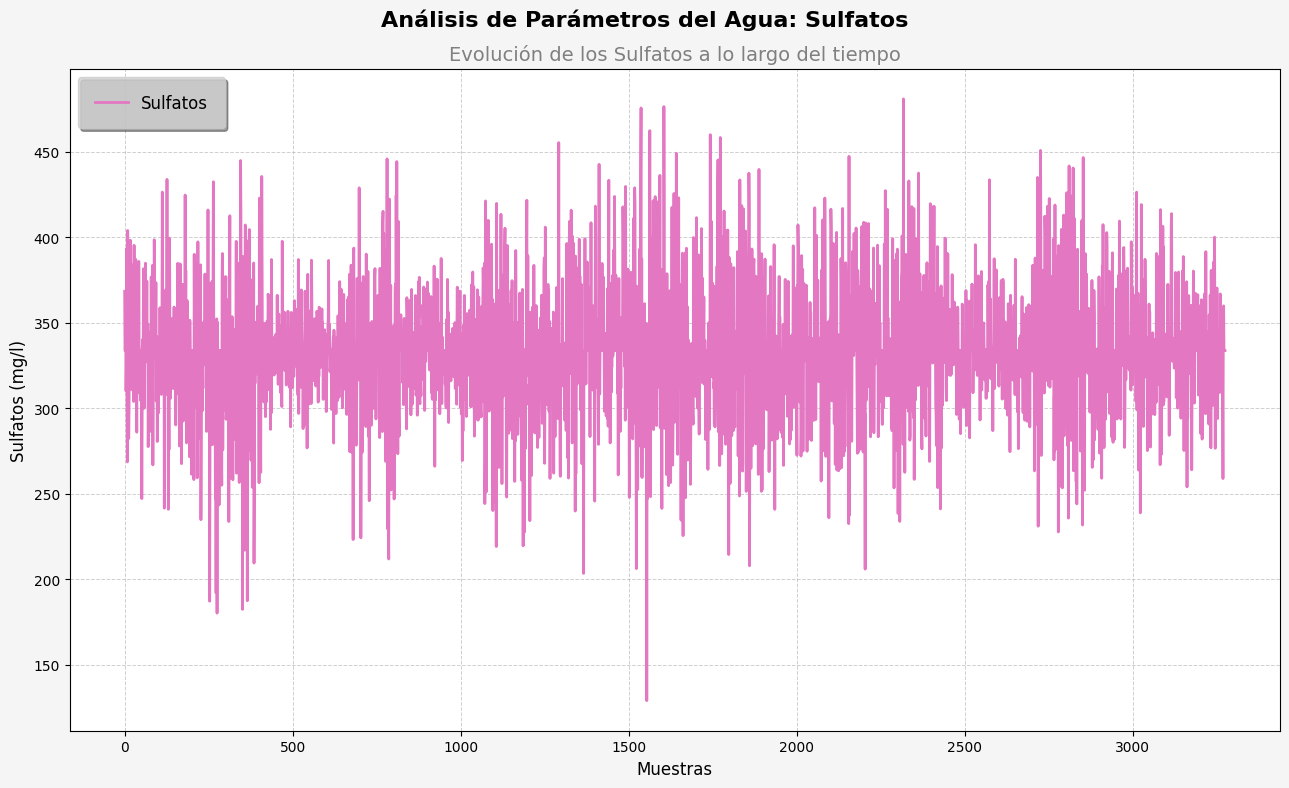

In [57]:
# Graficar el parámetro sulfate
tam = len(Sulfate_parametro)
fig, ax5 = plt.subplots(figsize=(13, 8))
ax5.plot(range(0, tam), Sulfate_parametro, label='Sulfatos', color='tab:pink', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Sulfatos', fontsize=16, fontweight='bold', color='black')
ax5.set_title('Evolución de los Sulfatos a lo largo del tiempo', fontsize=14, color='grey')
ax5.set_xlabel('Muestras', fontsize=12)
ax5.set_ylabel('Sulfatos (mg/l)', fontsize=12)

# Leyenda
legend = ax5.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax5.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

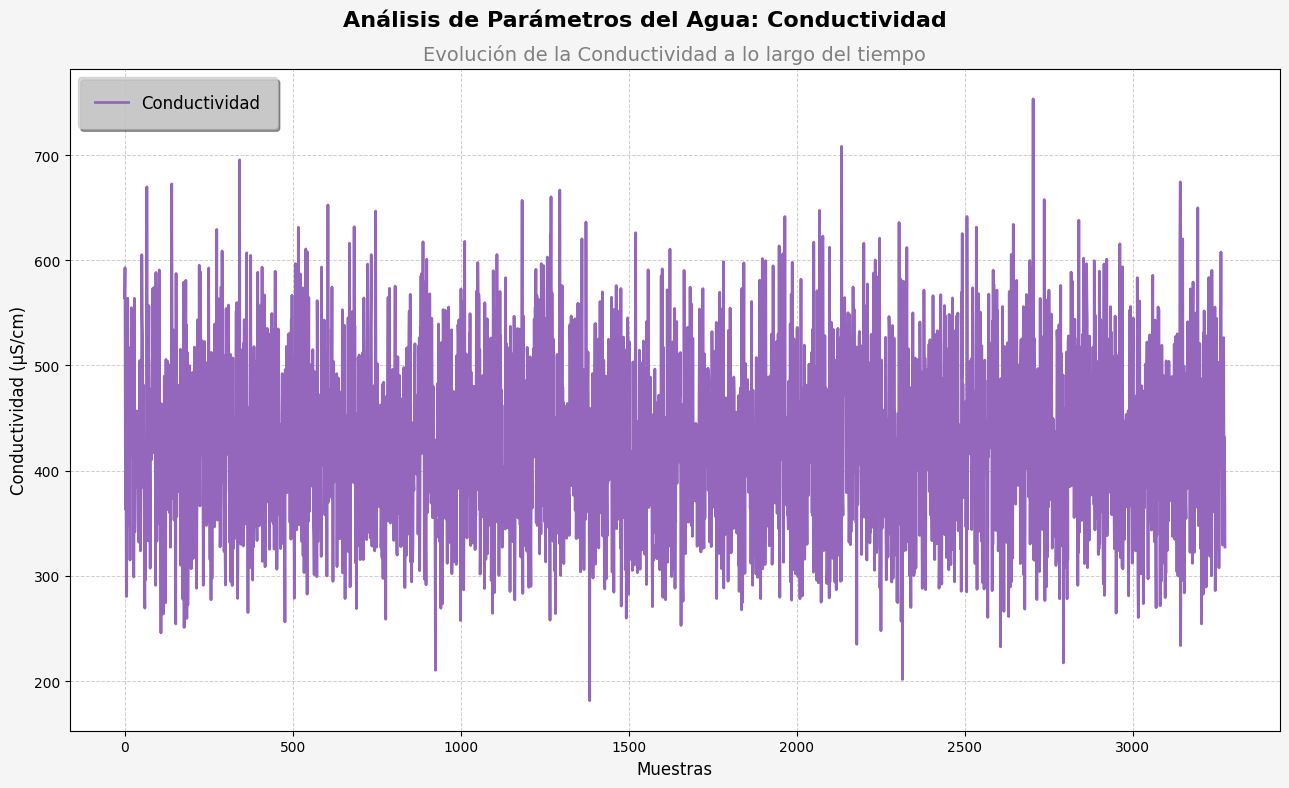

In [58]:
# Graficar el parámetro Conductivity
tam = len(Conductivity_parametro)
fig, ax6 = plt.subplots(figsize=(13, 8))
ax6.plot(range(0, tam), Conductivity_parametro, label='Conductividad', color='tab:purple', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Conductividad', fontsize=16, fontweight='bold', color='black')
ax6.set_title('Evolución de la Conductividad a lo largo del tiempo', fontsize=14, color='grey')
ax6.set_xlabel('Muestras', fontsize=12)
ax6.set_ylabel('Conductividad (μS/cm)', fontsize=12)

# Leyenda
legend = ax6.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax6.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

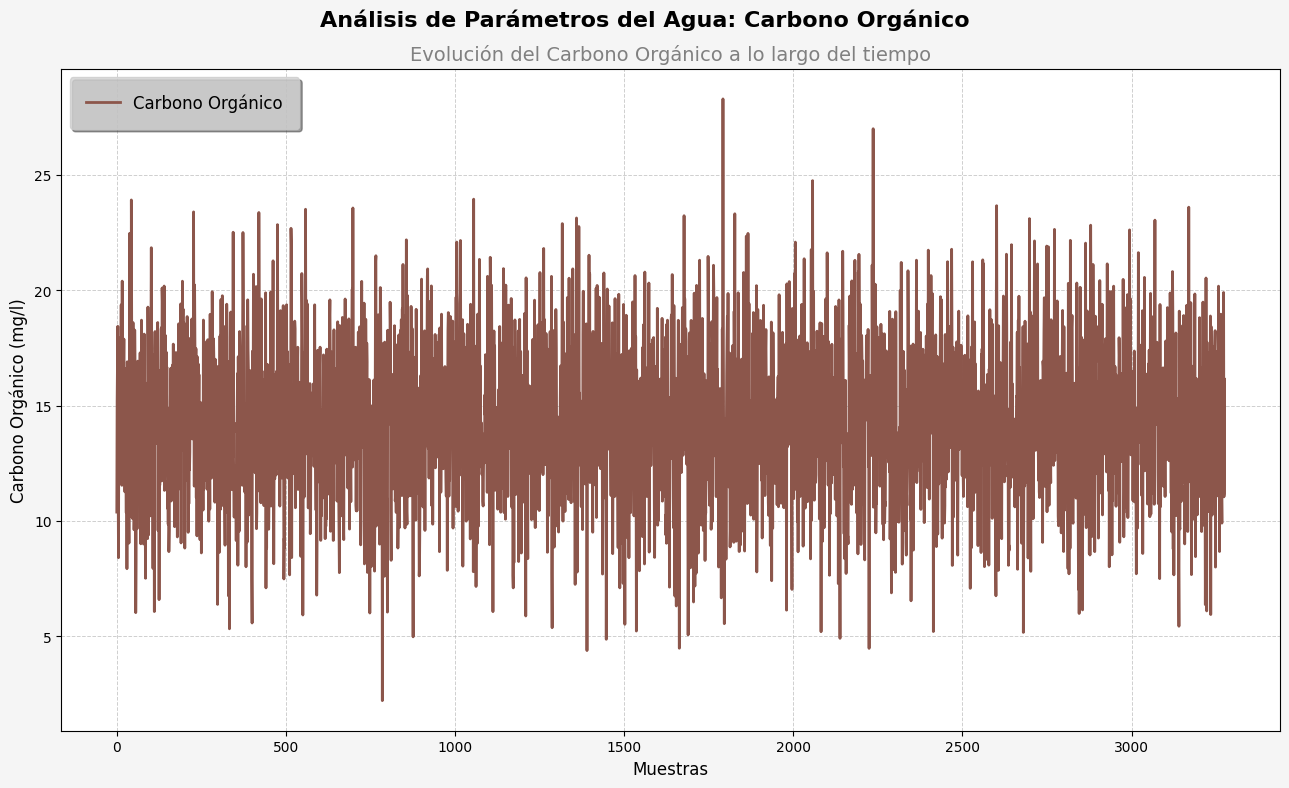

In [59]:
# Graficar el parámetro organic carbon
tam = len(Organic_carbon_parametro)
fig, ax7 = plt.subplots(figsize=(13, 8))
ax7.plot(range(0, tam), Organic_carbon_parametro, label='Carbono Orgánico', color='tab:brown', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Carbono Orgánico', fontsize=16, fontweight='bold', color='black')
ax7.set_title('Evolución del Carbono Orgánico a lo largo del tiempo', fontsize=14, color='grey')
ax7.set_xlabel('Muestras', fontsize=12)
ax7.set_ylabel('Carbono Orgánico (mg/l)', fontsize=12)

# Leyenda
legend = ax7.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax7.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

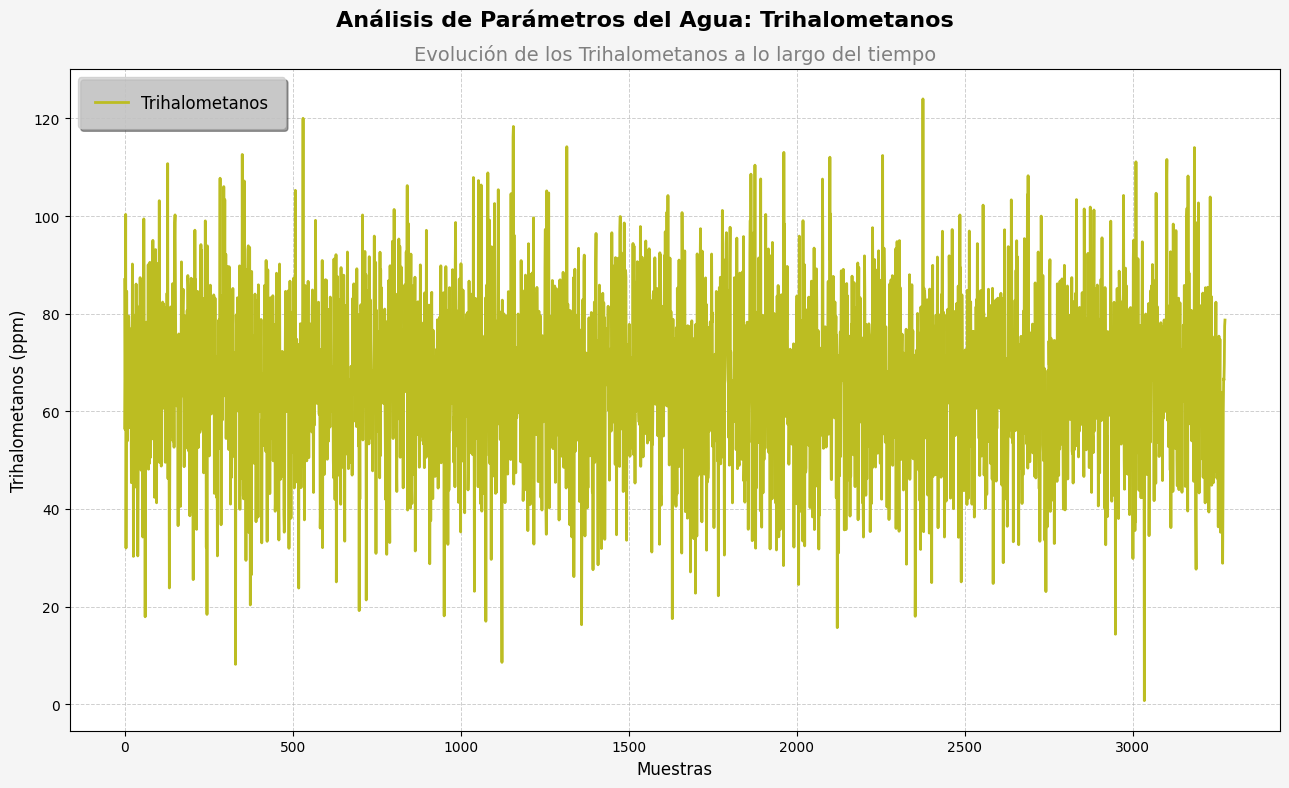

In [60]:
# Graficar el parámetro Trihalomethanes
tam = len(Trihalomethanes_parametro)
fig, ax8 = plt.subplots(figsize=(13, 8))
ax8.plot(range(0, tam), Trihalomethanes_parametro, label='Trihalometanos', color='tab:olive', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Trihalometanos', fontsize=16, fontweight='bold', color='black')
ax8.set_title('Evolución de los Trihalometanos a lo largo del tiempo', fontsize=14, color='grey')
ax8.set_xlabel('Muestras', fontsize=12)
ax8.set_ylabel('Trihalometanos (ppm)', fontsize=12)

# Leyenda
legend = ax8.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax8.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

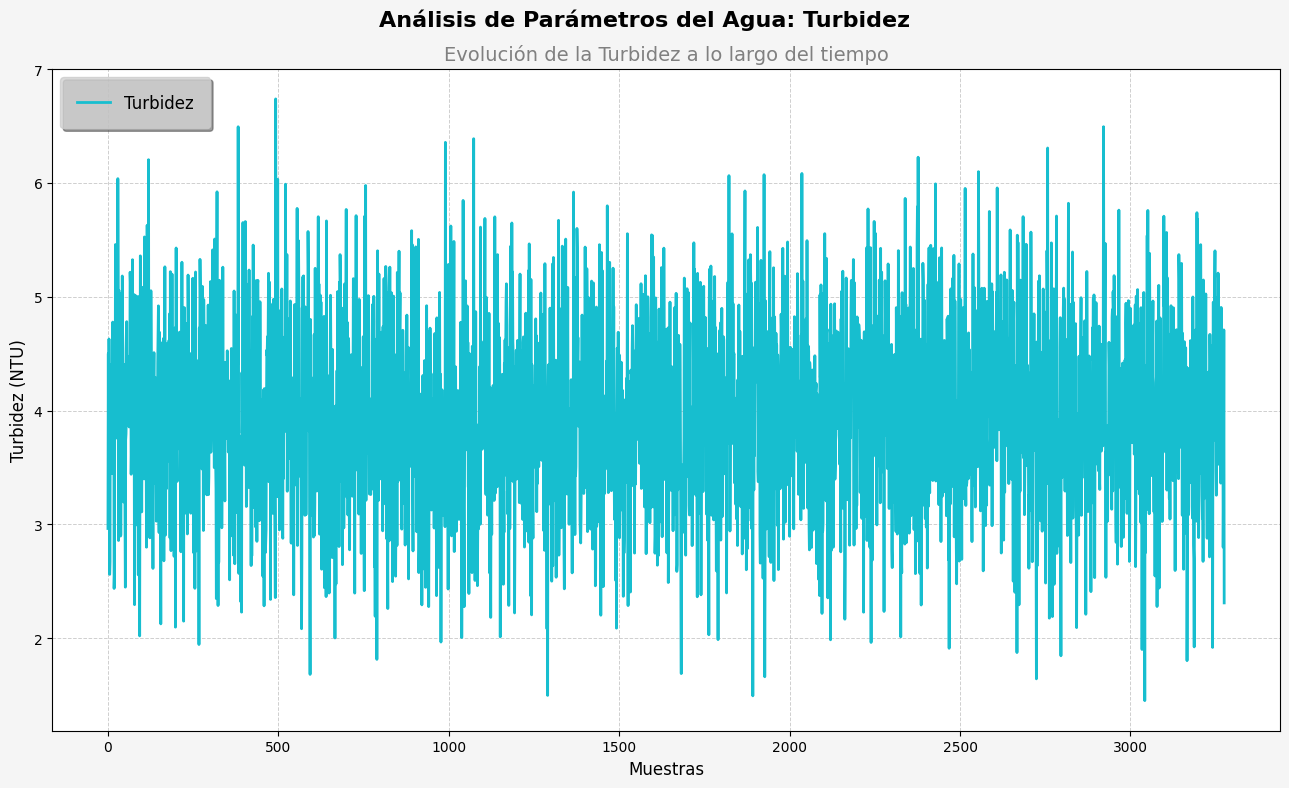

In [61]:
# Graficar el parámetro Turbidity
tam = len(Turbidity_parametro)
fig, ax9 = plt.subplots(figsize=(13, 8))
ax9.plot(range(0, tam), Turbidity_parametro, label='Turbidez', color='tab:cyan', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Turbidez', fontsize=16, fontweight='bold', color='black')
ax9.set_title('Evolución de la Turbidez a lo largo del tiempo', fontsize=14, color='grey')
ax9.set_xlabel('Muestras', fontsize=12)
ax9.set_ylabel('Turbidez (NTU)', fontsize=12)

# Leyenda
legend = ax9.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax9.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

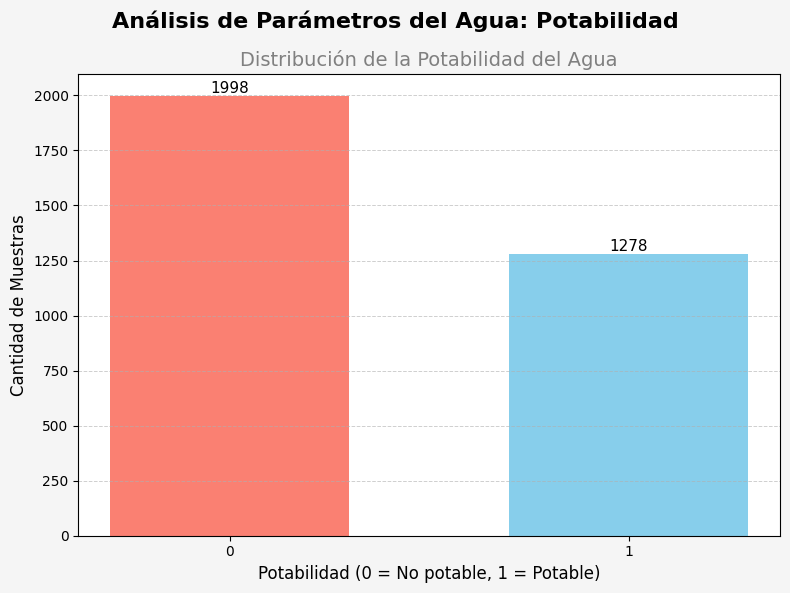

In [62]:
# Contar cuántos valores hay de cada categoría
conteo_potabilidad = pd.Series(Potability_parametro).value_counts().sort_index()

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(conteo_potabilidad.index.astype(str), conteo_potabilidad.values, color=['salmon', 'skyblue'], width=0.6)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Potabilidad', fontsize=16, fontweight='bold', color='black')
ax.set_title('Distribución de la Potabilidad del Agua', fontsize=14, color='grey')
ax.set_xlabel('Potabilidad (0 = No potable, 1 = Potable)', fontsize=12)
ax.set_ylabel('Cantidad de Muestras', fontsize=12)

# Mostrar valores en las barras
for i, v in enumerate(conteo_potabilidad.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=11)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Creación de los Modelos de Clasificación

In [63]:
#importar la biblioteca
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve, auc

In [64]:
#Vector ensamblador para la creación de la columna features
vEnsamblador = VectorAssembler(inputCols=['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity'], outputCol='features')

#Separación de datos aleatoriamente: 20% para prueba
train_data, test_data = df02.randomSplit([0.8, 0.2])

### Creación del Modelo de Regresión Logistica


In [65]:
#Se prepara el modelo de Regresión Logistica
from pyspark.ml.classification import LogisticRegression

modelo_B_Log = LogisticRegression(featuresCol="features", labelCol="Potability")

#Se crea el pipeline
pipe_A = Pipeline(stages=[vEnsamblador, modelo_B_Log])

In [66]:
# Fitting the model on training data
results_ModeloB = pipe_A.fit(train_data).transform(test_data)

# Showing the results
results_ModeloB.select("Potability", "prediction").show(15)

+----------+----------+
|Potability|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
+----------+----------+
only showing top 15 rows



In [67]:
# Calling the evaluator
res = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Potability')

# Evaluating the AUC on results
ROC_AUC = res.evaluate(results_ModeloB)

#Impresión Valor ROC_AUC
print("ROC AUC para Regresion Logistica:", ROC_AUC)

ROC AUC para Regresion Logistica: 0.5021367521367521


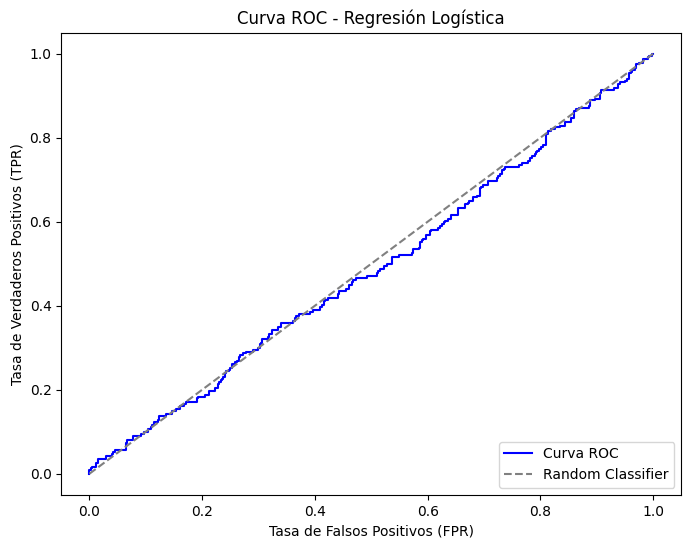

In [68]:
# Graficar la curva ROC
predictionAndLabels = results_ModeloB.select("prediction", "Potability").rdd.map(lambda row: (float(row.prediction), float(row.Potability)))

# Crear el objeto BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Obtener las probabilidades y las etiquetas para la curva ROC
y_score = results_ModeloB.select("probability").rdd.map(lambda x: float(x[0][1])).collect()
y_true = results_ModeloB.select("Potability").rdd.map(lambda x: float(x[0])).collect()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.title('Curva ROC - Regresión Logística')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

### Creación del Modelo de Redes Neuronales

In [69]:
#Se prepara la Red Neuronal
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Se Definien las capas de la red: [n_entradas, capas ocultas, n_salida]
capas = [9, 100, 2]
epocas = 1000

# Se instancia del modelo de red neuronal
modelo_red_neuronal = MultilayerPerceptronClassifier(featuresCol='features', labelCol='Potability', maxIter=epocas, layers=capas, blockSize=128, seed=100)

In [70]:
#Se crea el pipeline
pipe_B = Pipeline(stages=[vEnsamblador, modelo_red_neuronal])

# Fitting the model on training data
Results_red = pipe_B.fit(train_data).transform(test_data)

# Showing the results
Results_red.select("Potability", "prediction").show(15)

+----------+----------+
|Potability|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       0.0|
+----------+----------+
only showing top 15 rows



In [71]:
# Calling the evaluator
res = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Potability')

# Evaluating the AUC on results
ROC_AUC_RN= res.evaluate(Results_red)

#Impresión Valor ROC_AUC
print("ROC AUC para Red Neuronal:", ROC_AUC_RN)

ROC AUC para Red Neuronal: 0.49876237623762376


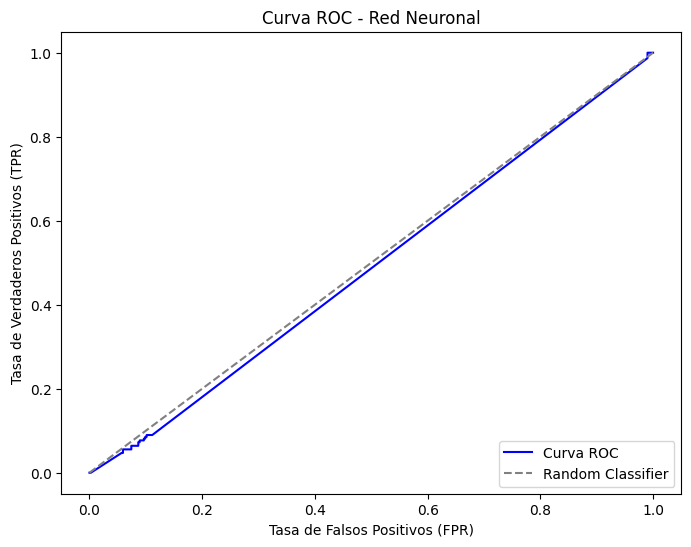

In [72]:
# Graficar la curva ROC
predicciones = Results_red.select("Potability", "probability").rdd
predicciones = predicciones.map(lambda x: (float(x[1][1]), float(x[0])))  # (score, label)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Potability", metricName="areaUnderROC")

# Calcular el AUC
roc_auc = evaluator.evaluate(Results_red)
predictionAndLabels = Results_red.select("prediction", "Potability").rdd.map(lambda row: (float(row.prediction), float(row.Potability)))
metrics = BinaryClassificationMetrics(predictionAndLabels)
y_score = Results_red.select("probability").rdd.map(lambda x: float(x[0][1])).collect()
y_true = Results_red.select("Potability").rdd.map(lambda x: float(x[0])).collect()
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.title('Curva ROC - Red Neuronal')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Referencias

* **[1]** Spellman FR. Handbook of Water and Wastewater Treatment Plant Operations. 3rd ed. Boca Raton: CRC Press; 2013.
* **[2]** Summer Kevin. [Water Quality](https://www.intechopen.com/chapters/69568). IntechOpen; DOI 978-1-78985-578-4.2020.
* **[3]** Hammer MJ. Water and Wastewater Technology. 7th ed. Upper Saddle River: Pearson education; 2011.
* **[4]** Tchobanoglous G, Burton FL, Stensel HD. Metcalf & Eddy Wastewater Engineering: Treatment and Reuse. 4th ed. New Delhi: Tata McGraw-Hill Limited; 2003.
* **[5]** Alley ER. Water Quality Control Handbook. Vol. 2. New York: McGraw-Hill; 2007.

* **[6]** Nathanson JA. Basic Environmental Technology: Water Supply. New Delhi: Printice-Hall of India; 2004

